<a href="https://colab.research.google.com/github/AsmaBenHmidene/food-sales-predictions/blob/main/Project_1_Revisited.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
pd.set_option('display.max_columns',100)

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer

# Set pandas as the default output for sklearn
from sklearn import set_config
set_config(transform_output='pandas')

## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib

# ## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
plt.style.use(('ggplot','tableau-colorblind10'))

In [ ]:
# Load data from file structure
filename = '/content/drive/MyDrive/Coding Dojo/ DATA SCIENCE FUNDAMENTALS/Week2/sales_predictions_2023 (1).csv'
df = pd.read_csv(filename)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# Cleaning data:

In [ ]:
df.shape

(8523, 12)

In [ ]:
df.duplicated().sum()

0

no duplicates

In [ ]:
df.nunique()

Item_Identifier              1559
Item_Weight                   415
Item_Fat_Content                5
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     3
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
dtype: int64

we will drop the 'Item_Identifier' column due to high cardinality, (1559 is a high number of unique labels).

In [ ]:
df= df.drop(columns=['Item_Identifier'])
df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [ ]:
df.isna().sum()

Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

NaN value of Item_Weight will be replaced with the mean value.

NaN value of Outlet_Size will be replaced with the most frequent category.

In [ ]:
df.select_dtypes('object').nunique()

Item_Fat_Content         5
Item_Type               16
Outlet_Identifier       10
Outlet_Size              3
Outlet_Location_Type     3
Outlet_Type              4
dtype: int64

In [ ]:
df['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [ ]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('LF','Low Fat').replace('low fat','Low Fat').replace('reg','Regular')
df['Item_Fat_Content'].value_counts(normalize = True).mul(100).round(2)

Low Fat    64.73
Regular    35.27
Name: Item_Fat_Content, dtype: float64

In [ ]:
df.describe().round(2)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.00,8523.00,8523.00,8523.00,8523.00
mean,12.86,0.07,140.99,1997.83,2181.29
std,4.64,0.05,62.28,8.37,1706.50
min,4.56,0.00,31.29,1985.00,33.29
25%,8.77,0.03,93.83,1987.00,834.25
50%,12.60,0.05,143.01,1999.00,1794.33
75%,16.85,0.09,185.64,2004.00,3101.30
max,21.35,0.33,266.89,2009.00,13086.96


# Exploratory Visuals & Analysis:

## Numerical columns:

In [ ]:
num_cols = df.select_dtypes('number').columns
num_cols

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales'],
      dtype='object')

In [ ]:
def plot_numeric(df,col):
  """EDA function to plot a histogram and boxplot for the selected column"""
  ## make the figure and axes sharing the same x-axis
  fig, axes = plt.subplots(nrows=2, figsize=(10,5), sharex=True)

  ## Use seaborn plots with ax=axes[i]
  sns.histplot(data=df,x = col,ax = axes[0])
  mean_value = df[col].mean()
  axes[0].axvline(mean_value,color='red', ls='--',
           label=f"Mean Value = ${mean_value:,.2f}",);

  med_value = df[col].median()
  axes[0].axvline(med_value,color='black', ls='--',
           label=f"Median Value = ${med_value:,.2f}");


  sns.boxplot(data=df, x = col, ax = axes[1])

  ## Updating title of top graph
  axes[0].set_title(f'EDA for {col}')

  ## Fixing any overlapping labels and showing
  plt.tight_layout()
  plt.show()

In [ ]:
def plot_dist(data, col, title, figure_size=(10,5)):
  fig, ax = plt.subplots(figsize=figure_size)

  ## Plot histogram
  sns.histplot(data=data,x=col,ax=ax)
  ax.set_title(title);
  ax.set_ylabel('Count')
  ax.set_xlabel('Outlet Sales')
  ax.set_xlim(left=0,right=12000)
  ax.set_ylim(bottom=0,top=650)

  ## Annotating mean and median
  mean_price = data[col].mean()
  ax.axvline(mean_price,color='slategray', ls='--', lw=3, label=f"Mean= {mean_price:,.2f}");

  med_price = data[col].median()
  ax.axvline(med_price,color='skyblue', ls=':', lw=3, label=f"Median= {med_price:,.2f}");

  ax.legend();

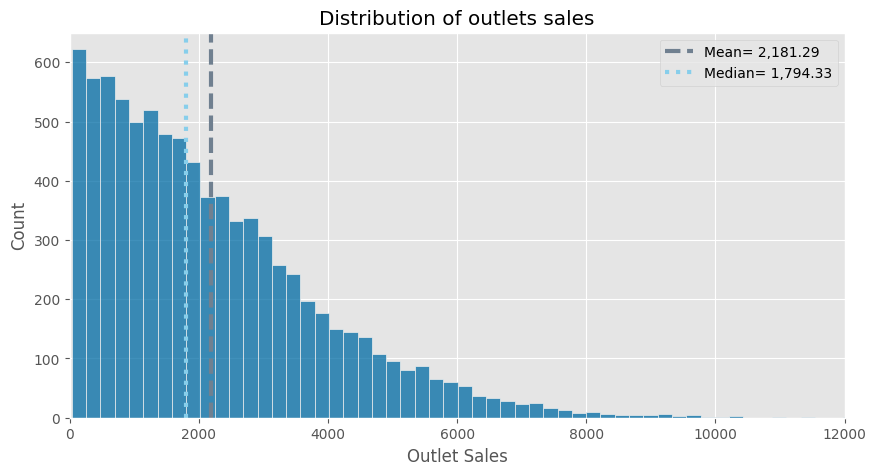

In [ ]:
plot_dist(df, "Item_Outlet_Sales", "Distribution of outlets sales")

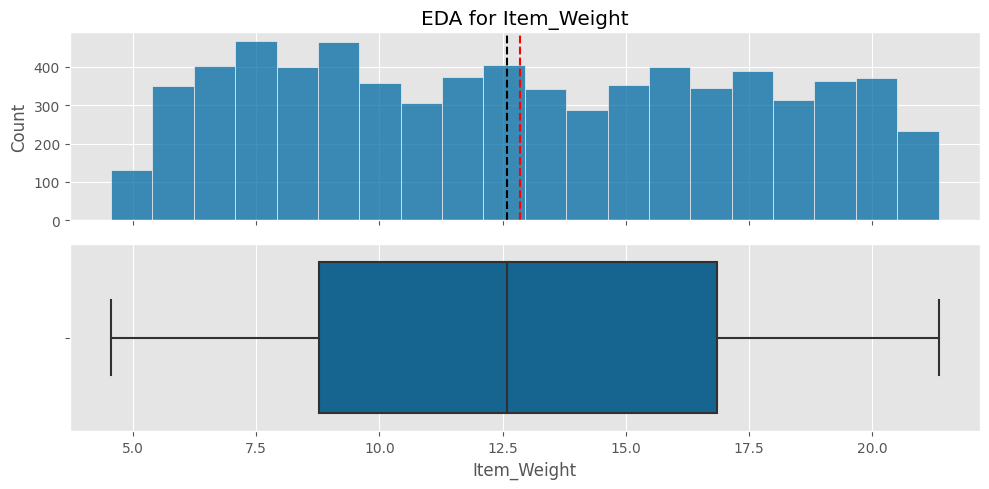

In [ ]:
plot_numeric(df,'Item_Weight')

In [ ]:
mean_price = df['Item_Weight'].mean()
print(f"Mean= {mean_price:,.2f}");

med_price = df['Item_Weight'].median()
print(f"Median= {med_price:,.2f}");

Mean= 12.86
Median= 12.60


Item_Weight column contains NaN values. we will impute them with the mean value.

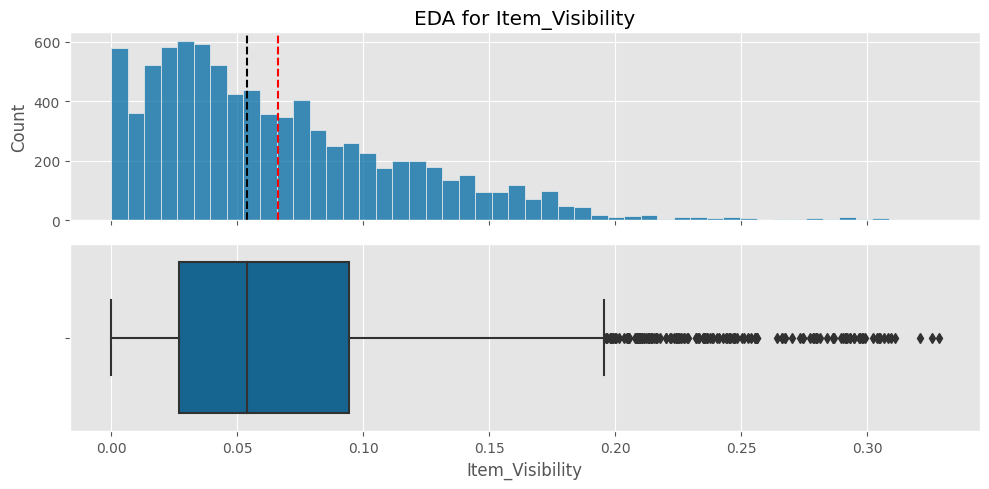

In [ ]:
plot_numeric(df,'Item_Visibility')

In [ ]:
mean_price = df['Item_Visibility'].mean()
print(f"Mean= {mean_price:,.2f}");

med_price = df['Item_Visibility'].median()
print(f"Median= {med_price:,.2f}");

Mean= 0.07
Median= 0.05


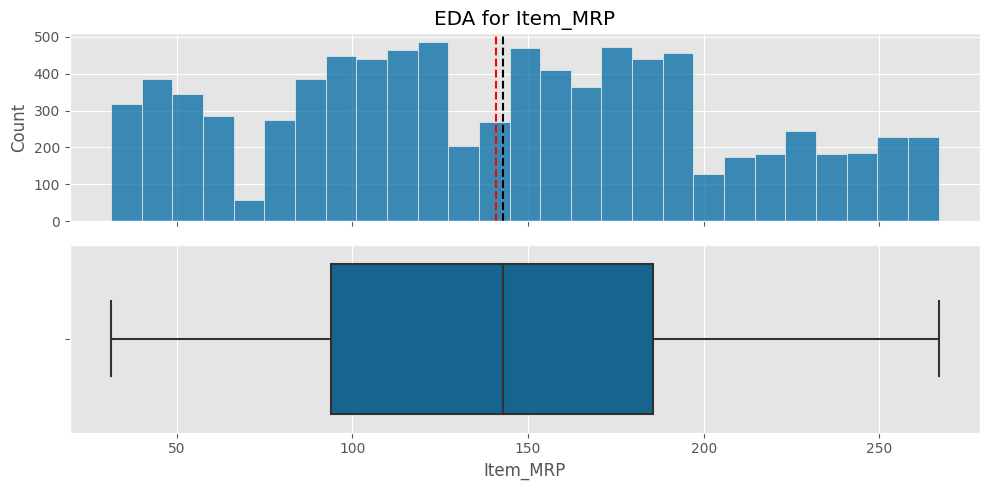

In [ ]:
plot_numeric(df,'Item_MRP')

In [ ]:
mean_price = df['Item_MRP'].mean()
print(f"Mean= {mean_price:,.2f}");

med_price = df['Item_MRP'].median()
print(f"Median= {med_price:,.2f}");

Mean= 140.99
Median= 143.01


## Categorical columns:

In [ ]:
## functionize a barplot and call it plot_bar

def plot_bar(data,x, y, figsize=(10,5)):
    ## Make a larger fig/ax before plotting
    fig, ax = plt.subplots(figsize=figsize)

    ## Plot barplot

    ## counts, counts up the categories, sort the values, then puts them in a
    ## data frame.

    counts = df[x].value_counts().sort_values(ascending=False).to_frame()
    ## ploting the barplot

    sns.barplot(data=counts,x=counts.index, y = counts[x],ax=ax)

    plt.xticks(rotation= 90)
    ax.set_title(f'Categorical Frequencies of {y}', fontsize = 20, fontweight = 'bold');
    ax.set_xlabel(f'Categories for {y}', fontsize = 15, fontweight = 'bold')
    ax.set_ylabel('Counts', fontsize = 15, fontweight = 'bold')

    return fig,ax


In [ ]:
cat_cols = df.select_dtypes('object').columns
cat_cols

Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64


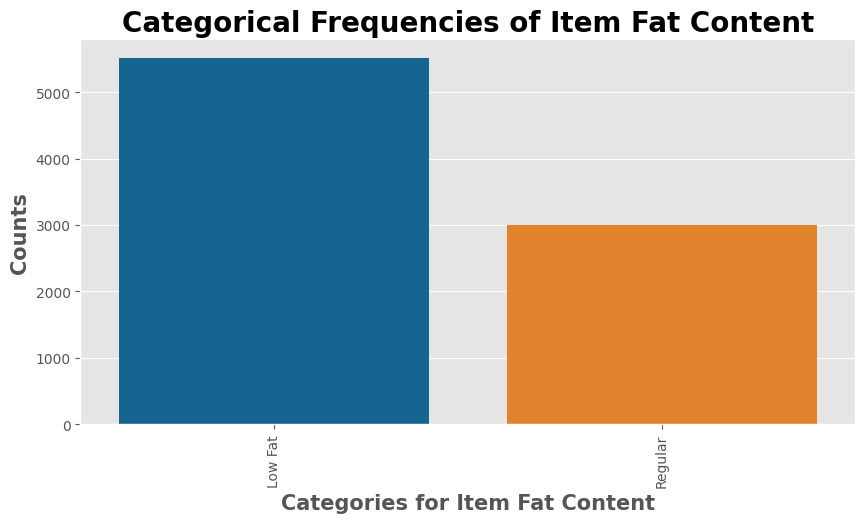

In [ ]:
fig, ax = plot_bar(df, 'Item_Fat_Content', 'Item Fat Content');
print(df['Item_Fat_Content'].value_counts())

Most of the products are classified as low fat items.

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64


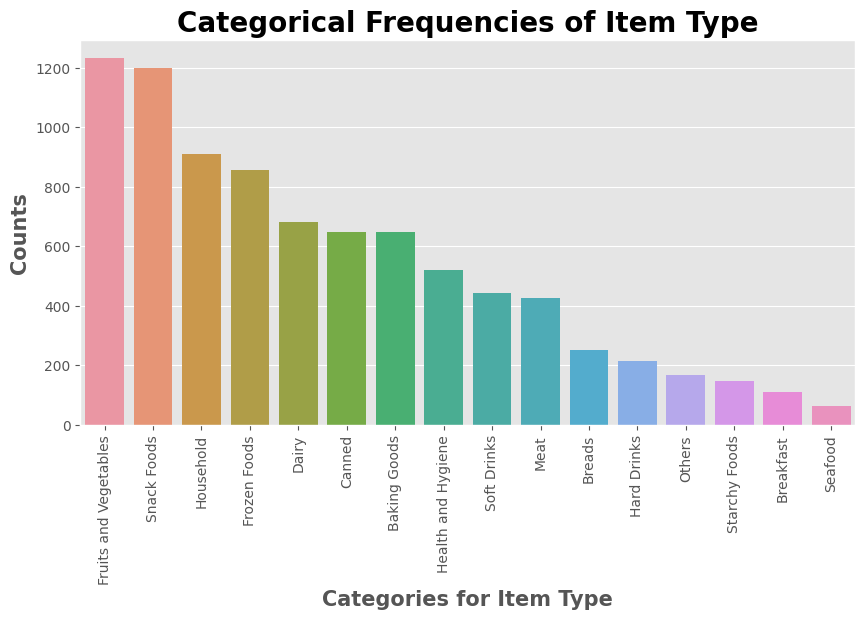

In [ ]:
fig, ax = plot_bar(df, 'Item_Type', 'Item Type');
print(df['Item_Type'].value_counts())

Fruits and vegetables are the main products offered for sales in the outlets, while seafood are the least frequent one.

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64


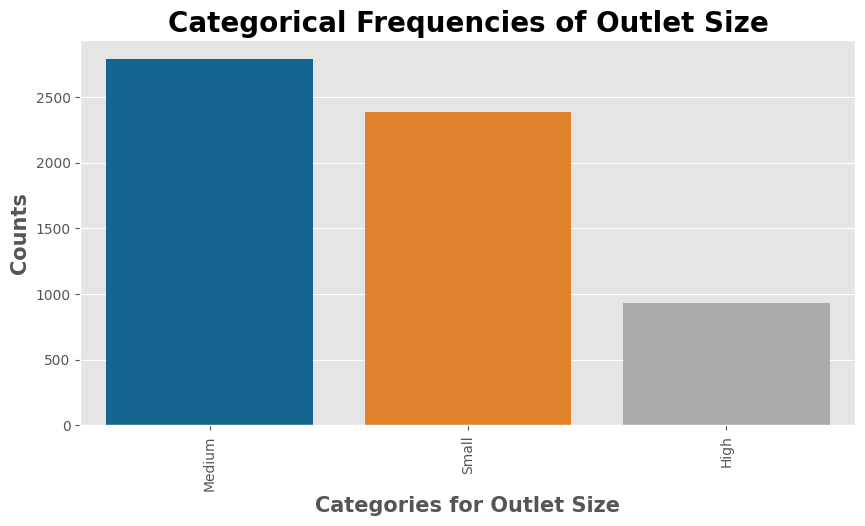

In [ ]:
fig, ax = plot_bar(df, 'Outlet_Size', 'Outlet Size');
print(df['Outlet_Size'].value_counts())

Most of the outlets have a medium size.

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64


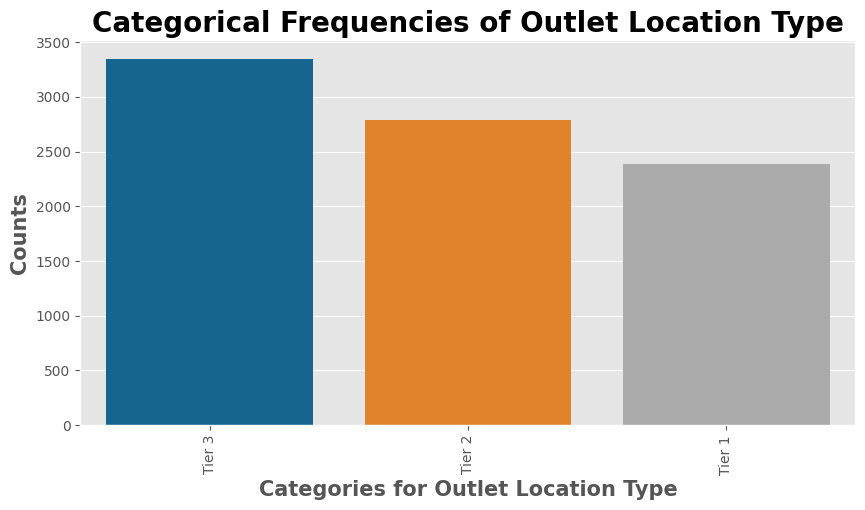

In [ ]:
fig, ax = plot_bar(df, 'Outlet_Location_Type', 'Outlet Location Type');
print(df['Outlet_Location_Type'].value_counts())

Most of the outlets are located in Tier 3 location type.

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64


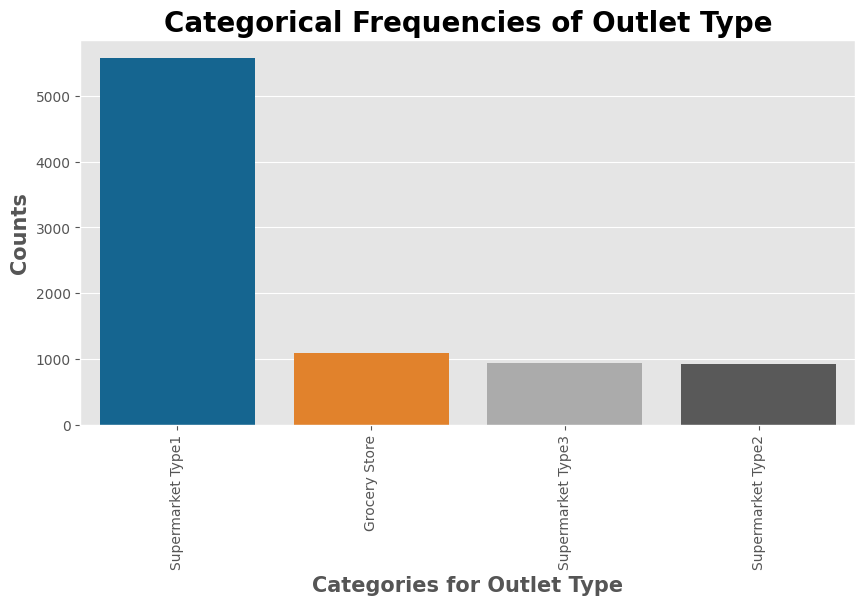

In [ ]:
fig, ax = plot_bar(df, 'Outlet_Type', 'Outlet Type');
print(df['Outlet_Type'].value_counts())

Supermarket Type 1 represent the main market category.

Analyse the relation between Item Outlet Sales and Item Type/Item Fat Content:

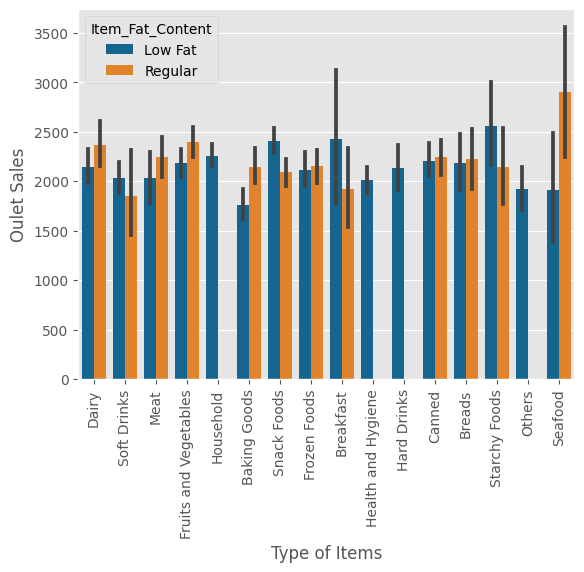

In [ ]:
sns.barplot(data=df, x='Item_Type', y="Item_Outlet_Sales", hue='Item_Fat_Content');
plt.ylabel('Oulet Sales')
plt.xlabel('Type of Items')
plt.xticks(rotation = 90);

Regular products represent the principle sales and more specifically seafood. Fruits and vegetables come in the second position even though they represent the main products offered for sales. For Low fat item, starchy foods represent the most selled product.

Analyse the relation between Item Outlet Sales and Outlet_Type:

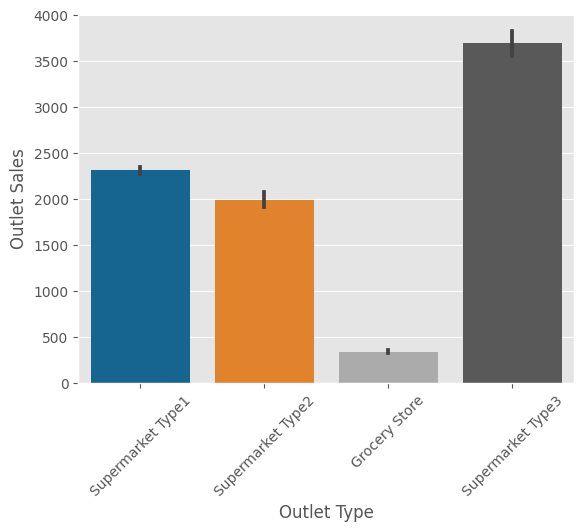

In [ ]:
sns.barplot(data=df, x='Outlet_Type', y="Item_Outlet_Sales");
plt.xticks(rotation = 45);
plt.ylabel('Outlet Sales')
plt.xlabel('Outlet Type');

Supermarket Type3 shows the highest sales average (3700). Supermarket Type 1 come in the second position (2400 sales' average) even though they are the main type among all outlets.

Analyse the relation between Item Outlet Sales and Outlet location type:

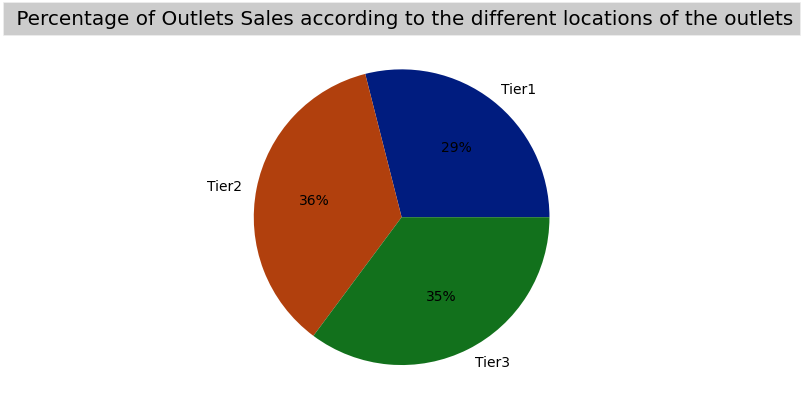

In [ ]:
data=df.groupby('Outlet_Location_Type')['Item_Outlet_Sales'].mean().round(2)
labels = ['Tier1', 'Tier2', 'Tier3']
colors = sns.color_palette('dark')[0:5]
plt.pie( data, labels = labels, colors = colors, autopct='%.0f%%')
plt.title(" Percentage of Outlets Sales according to the different locations of the outlets", bbox={'facecolor':'0.8', 'pad':5})
plt.show()

Outlets in location Tier 3 and Tier 2 show the highest sales percentage.

Analyse the relation between Item Outlet Sales and Outlet Size:

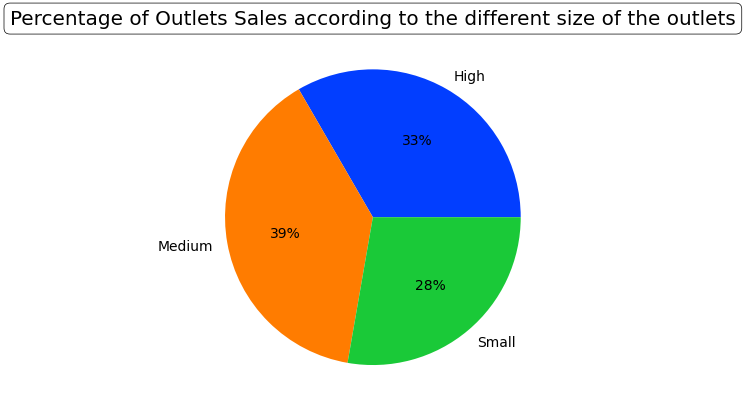

In [ ]:
data=df.groupby('Outlet_Size')['Item_Outlet_Sales'].mean().round(2)
labels = ['High', 'Medium', 'Small']
colors = sns.color_palette('bright')[0:5]
plt.pie( data, labels = labels, colors = colors, autopct='%.0f%%')
plt.title("Percentage of Outlets Sales according to the different size of the outlets", bbox={'facecolor':'none', 'edgecolor':'black', 'boxstyle':'round', 'pad': 0.3})
plt.show()

Most sales are done in medium size outlets. Outlet_Size column contains NaN value, we will impute them with the most frequent category which is 'Medium'.

Analyse the relation between Item Outlet Sales and Item MRP:

In [ ]:
corr = df.corr()

<ipython-input-127-45893e33df67>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


(<Axes: >,)

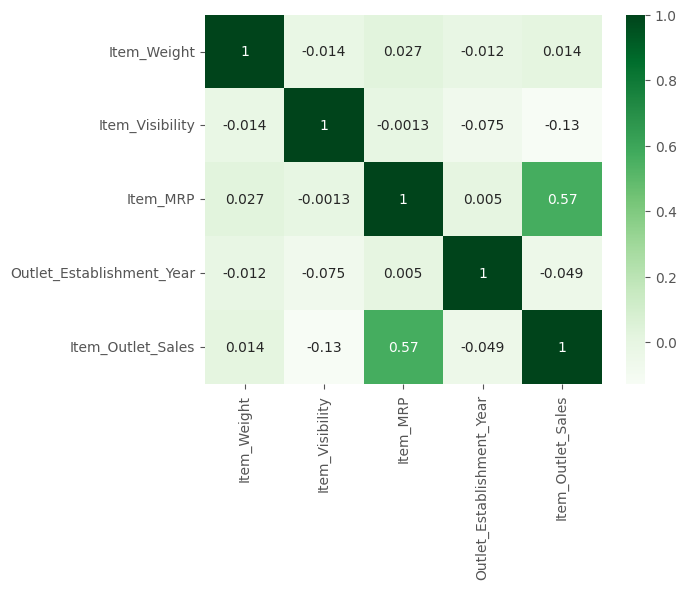

In [ ]:
sns.heatmap(corr, cmap = 'Greens', annot = True),

There is a moderate correlation between Item Outlet sales and Item MRP(r=0.57).

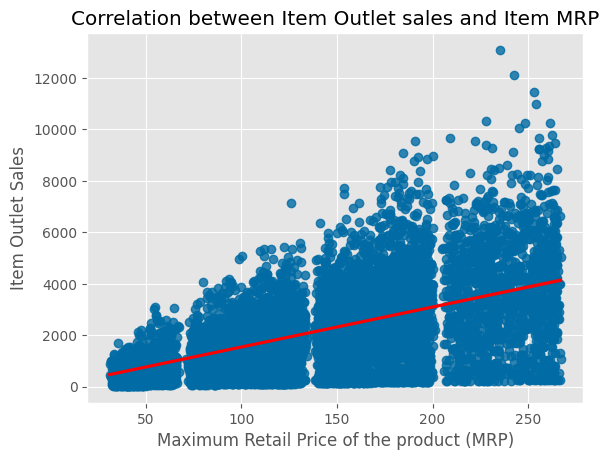

In [ ]:
sns.regplot(data=df, x='Item_MRP', y='Item_Outlet_Sales',line_kws = dict(color='red', ls='solid'));
plt.title("Correlation between Item Outlet sales and Item MRP")
plt.xlabel('Maximum Retail Price of the product (MRP)')
plt.ylabel('Item Outlet Sales');

The scatterplot correlating Item outlet sales with item MRP shows 4 groups. Items with MRP between 20 and 70 (group 1) show the lowest sales average, followed by Items with MRP between 80 and 140 (group 2), then Items with MRP between 140 and 200 (group 3) and finally Items with sales between 210 and 270 (group 4) that represent the highest items'sales .

There are a positive correlation between the outlet sales and MRP. The sales increase whith the increase of the MRP of the product.

# Pre-processing:

## Preprocess the data as dataframes with feature names using the updated column transformer:

Remake your X_train and X_test as DataFrames with the feature names extracted from the column transformer instead of combining your preprocessor and model into 1 pipeline.

In [ ]:
#Identify the features (X) and target (y)
y = df['Item_Outlet_Sales']
X = df.drop(columns=['Item_Outlet_Sales','Outlet_Identifier','Outlet_Establishment_Year'])

In [ ]:
## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)
X_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type
8269,7.220,Regular,0.064142,Baking Goods,61.2510,NaN,Tier 3,Grocery Store
7604,6.135,Low Fat,0.079294,Soft Drinks,111.2860,Medium,Tier 3,Supermarket Type2
2762,12.150,Low Fat,0.028593,Household,151.0708,Small,Tier 2,Supermarket Type1
6464,5.945,Low Fat,0.093009,Household,127.8652,Small,Tier 2,Supermarket Type1
4707,18.200,Regular,0.066285,Fruits and Vegetables,247.2092,Small,Tier 2,Supermarket Type1


In [ ]:
## Create categorical pipeline
cat_selector = X_train.select_dtypes('object').drop(columns= ['Outlet_Size']).columns
# create pipeline for handling categorical data
impute_most_freq = SimpleImputer(strategy='most_frequent')
encoder = OneHotEncoder(handle_unknown='ignore',sparse=False)
cat_pipe = make_pipeline(impute_most_freq,encoder)

## Create numeric pipelien
num_selector = make_column_selector(dtype_include='number')
num_selector(X_train)
# create pipeline for handling categorical data
impute_mean = SimpleImputer(strategy='mean')
scaler = StandardScaler()
num_pipe = make_pipeline(impute_mean, scaler)

In [ ]:
# Defining lists of ordinal features
ord_cols = ['Outlet_Size']
# Specifying the order of categories in quality/condition columns
impute_na_ord = SimpleImputer(strategy= 'most_frequent')
## Making the OrdinalEncoder
# Specifying order of categories for our  Ordinal Qual/Cond Columms
qual_cond_order = ['High','Medium','Small']
# Making the list of order lists for OrdinalEncoder
ordinal_category_orders = [qual_cond_order]
ord_encoder = OrdinalEncoder(categories=ordinal_category_orders)
# Making a final scaler to scale category #'s
scaler_ord = StandardScaler()
# Instantiate the Pipeline
ord_pipe = make_pipeline(impute_na_ord, ord_encoder, scaler_ord)

In [ ]:
## Combine into 1 column transformer
preprocessor = make_column_transformer( (cat_pipe,cat_selector),
                                       (num_pipe,num_selector),
                                        (ord_pipe,ord_cols),
                                      verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Location_Type', 'Outlet_Type'], dtype='object')),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 (...
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7eeb2c3f45b0>),
                                ('pipeline-3',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['High',
                                                                              'Medium',
                                                                              'Small']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Outlet_Size'])],
                  verbose_feature_names_out=False)

In [ ]:
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          columns = feature_names, index = X_train.index)

X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                          columns = feature_names, index = X_test.index)
X_test_df.head(3)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Weight,Item_Visibility,Item_MRP,Outlet_Size
8077,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.571480,-0.093503,-0.120626,-0.287004
2391,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.183604,-0.421698,-0.204533,1.376216
163,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.307269,0.090081,-0.412092,1.376216


# 1. linear regression model to predict sales:

- Fit and evaluate your LinearRegresion model using your dataframe X_train and X_test data.
- Extract and visualize the coefficients that your model determined.
Select the top 3 most impactful features and interpret their coefficients in plain English.
- Save your figure as a .png file inside your repository (you will need this for the final piece of this assignment - Update Your README).

In [ ]:
## Make & Fit the modeling pipeline
lin_reg = LinearRegression()
pipe = make_pipeline(preprocessor, lin_reg)
pipe.fit(X_train, y_train)
## Quick peek at the R^2 value for test data
print(f"Training R2: {pipe.score(X_train,y_train) :.3f}")
print(f"Test R2: {pipe.score(X_test,y_test): .3f}");

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Training R2: 0.562
Test R2:  0.560


In [ ]:
def get_coeffs_linreg(lin_reg, feature_names = None, sort=True,ascending=True,
                     name='LinearRegression Coefficients'):
    if feature_names is None:
        feature_names = lin_reg.feature_names_in_
    ## Saving the coefficients
    coeffs = pd.Series(lin_reg.coef_, index= feature_names)
    coeffs['intercept'] = lin_reg.intercept_
    if sort==True:
        coeffs = coeffs.sort_values(ascending=ascending)
    return coeffs

In [ ]:
coeffs = get_coeffs_linreg(lin_reg)
coeffs

Outlet_Location_Type_Tier 1       -2.893431e+16
Outlet_Location_Type_Tier 2       -2.893431e+16
Outlet_Location_Type_Tier 3       -2.893431e+16
intercept                         -2.324310e+16
Item_Visibility                   -1.025000e+01
Item_Weight                        1.487500e+01
Outlet_Size                        1.668945e+01
Item_MRP                           9.631523e+02
Item_Type_Soft Drinks              9.048737e+15
Item_Type_Household                9.048737e+15
Item_Type_Dairy                    9.048737e+15
Item_Type_Breakfast                9.048737e+15
Item_Type_Meat                     9.048737e+15
Item_Type_Frozen Foods             9.048737e+15
Item_Type_Snack Foods              9.048737e+15
Item_Type_Canned                   9.048737e+15
Item_Type_Health and Hygiene       9.048737e+15
Item_Type_Others                   9.048737e+15
Item_Type_Starchy Foods            9.048737e+15
Item_Type_Baking Goods             9.048737e+15
Item_Type_Breads                   9.048

In [ ]:
def annotate_hbars(ax, ha='left', va='center', size=12, xytext=(4,0),
                  textcoords='offset points'):
    for bar in ax.patches:

        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height() / 2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha, va=va, size=size,
                        xytext=xytext, textcoords=textcoords)

In [ ]:
def plot_coeffs(coeffs, top_n=None, figsize=(4,5),
                intercept=False, intercept_name="intercept",
                annotate=False, ha='left', va='center', size=12,
                xytext=(4,0), textcoords='offset points'):
    """ Plots the top_n coefficients from a Series, with optional annotations.
    """
    # Drop intercept if intercept=False and
    if (intercept == False) & (intercept_name in coeffs.index):
        coeffs = coeffs.drop(intercept_name)
    if top_n == None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)

        ## sort features and keep top_n and set title
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient',
            ylabel='Feature Names',
            title=title)
    ax.axvline(0, color='k')
    if annotate == True:
        annotate_hbars(ax, ha=ha, va=va, size=size, xytext=xytext, textcoords=textcoords)
    return ax

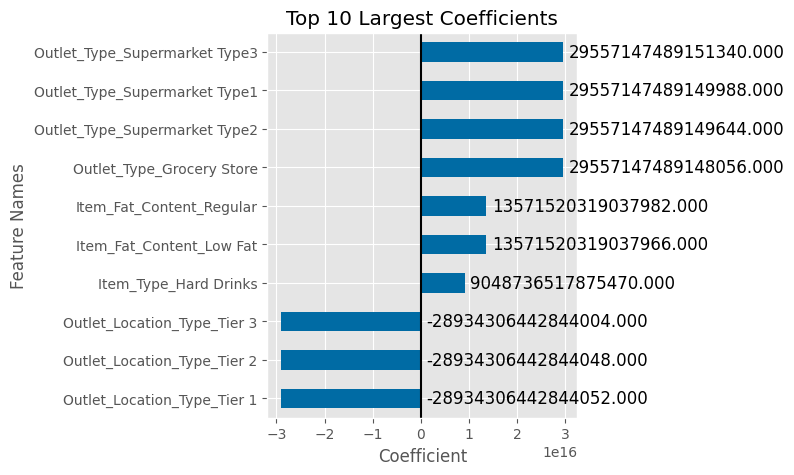

In [ ]:
ax = plot_coeffs(coeffs,top_n=10)
annotate_hbars(ax)

- the top 3 most impactful features are:
     - Outlet_Type_Supermarket
     - Item_fat_content
     - item_type_hard drinks

All these 3 features impact positively the outlets' sales.

The 4 types of supermarket shows an almost equal coefficients, with the supertmarket type 3 being the largest and increase the sales by 2.955715e+16.

The 2 types of Item_fat_content (regular and low fat) shows also almost equal coefficients, with the regular item content being the largest and increase the sales by 1.357152e+16.

Among all the Item types: Hard drinks shows the largest coefficient and increase the sales by 9.048737e+15.







# 2. Regression tree model to predict sales:

- Fit and evaluate your tree-based regression model using your dataframe X_train and X_test data.
- Extract and visualize the feature importances that your model determined.
- Identify the top 5 most important features.
- Save your figure as a .png file inside your repository  (you will need this for the final piece of this assignment - Update Your README).

In [ ]:
def evaluate_regression(model, X_train,y_train, X_test, y_test):
    """Evaluates a scikit-learn-compatible regression model using r-squared and RMSE

    Args:
        model (Regressor): Regression Model with a .predict method
        X_train (DataFrame): Training Features
        y_train (Series): Training Target
        X_test (DataFrame): Test Features
        y_test (Series): Test Target
    """

    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train,
                                            squared=False)

    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")


    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test,
                                            squared=False)

    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")

In [ ]:
reg = RandomForestRegressor()
reg.fit(X_train_df,y_train)
evaluate_regression(reg, X_train_df, y_train, X_test_df,y_test)

Training Data:	R^2= 0.93	RMSE= 431.10
Test Data:	R^2= 0.55	RMSE= 1178.83


In [ ]:
feature_importance = pd.Series(reg.feature_importances_, index=feature_names,
                        name='Feature Importances')
feature_importance.head()

Item_Fat_Content_Low Fat    0.004874
Item_Fat_Content_Regular    0.004645
Item_Type_Baking Goods      0.004507
Item_Type_Breads            0.002919
Item_Type_Breakfast         0.002466
Name: Feature Importances, dtype: float64

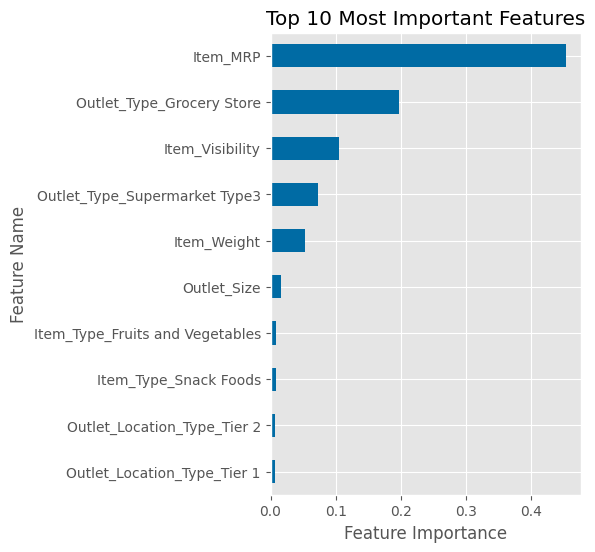

In [ ]:
ax = feature_importance.sort_values().tail(10).plot(kind='barh',figsize=(4,6))
ax.set(ylabel='Feature Name',xlabel='Feature Importance',
       title='Top 10 Most Important Features');

- the top 5 most important features are:
     - Item MRP
     - Outlet_Type_Grocery store
     - Item visibility
     - Outlet_Type_Supermarket Type3
     - item_Weight

# Serialize Your Best Models with Joblib:

Once you've finished updating and explaining your models, you must save the following key: value pairs as a dictionary in a joblib file named "best-models.joblib":

- "preprocessor": your preprocessing  column transformer
- "X_train": your training features.
- "X_test": your test features.
- "y_train": your training target.
- "y_test": your test target.
- "LinearRegression": your best linear regression
- Your tree-based model's class name: your best tree-based model.
e.g. "RandomForestRegressor"/"DecisionTreeRegressor"

Save your joblib file inside your repository. (You will work with these models again in the next core assignment.)

In [ ]:
## saving variables for next lesson/notebook
import joblib
## creating a dictionary of all of the variables to save for later
export = {'X_train':X_train_df,
         'y_train': y_train,
         'X_test':X_test_df,
          "y_test": y_test,
         'preprocessor':preprocessor,
          'LinearRegression': lin_reg,
         'RandomForest': reg}
joblib.dump(export, 'best-models.joblib')

['best-models.joblib']

# Update your README:
Insert your exported figures from above into your README file. You should have the following:

- Your LinearRegression coefficients plot.
- Your interpretation of your coefficients.
- Your tree-based model's feature importances.
- Your interpretation of your feature importances.
